In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from time import time
from PINN.VanillaOptions import VanillaOptionPINN
from PINN.utilities import V_BS, V_BS_CN, european_option_greeks

import warnings
warnings.filterwarnings("ignore")

## European Put Option

In [ ]:
# parameters
K = 4
sigma = 0.3
r = 0.03
T = 1
S_inf = 3 * K
N_pde = 2500

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

# load data
ib = torch.load('data/european_put_ib_sobol.pt')
S_ib, tau_ib, V_ib = ib['S'], ib['tau'], ib['V']

# load results
results_file = 'european_put.npy'
results = np.load(f'data/output/{results_file}', allow_pickle=True).item()
RMSE = results['RMSE']
MPE = results['MPE']  # max pointwise error

RMSE_mean = RMSE.mean()
RMSE_std = RMSE.std()
mpe_mean = MPE.mean()
mpe_std = MPE.std()
best_idx = np.argmin(RMSE)

GREEKS = results['GREEKS']
RMSE_greeks = {}
MPE_greeks = {}
for greek in GREEKS:
    RMSE_greeks[greek] = results[f'RMSE_{greek}']
    MPE_greeks[greek] = results[f'MPE_{greek}']
RMSE_greeks_mean = {greek: RMSE_greeks[greek].mean() for greek in GREEKS}
RMSE_greeks_std = {greek: RMSE_greeks[greek].std() for greek in GREEKS}
mpe_greeks_mean = {greek: MPE_greeks[greek].mean() for greek in GREEKS}
mpe_greeks_std = {greek: MPE_greeks[greek].std() for greek in GREEKS}

SEEDS = results['SEEDS']

model_name = f'european_put_{best_idx}'
model = torch.load(f'models/european_put/{model_name}.pt', map_location=device)

Device: cpu


VanillaOptionPINN(
  (V_nn): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Tanh()
    (4): Linear(in_features=20, out_features=1, bias=True)
  )
)
Number of parameters: 501


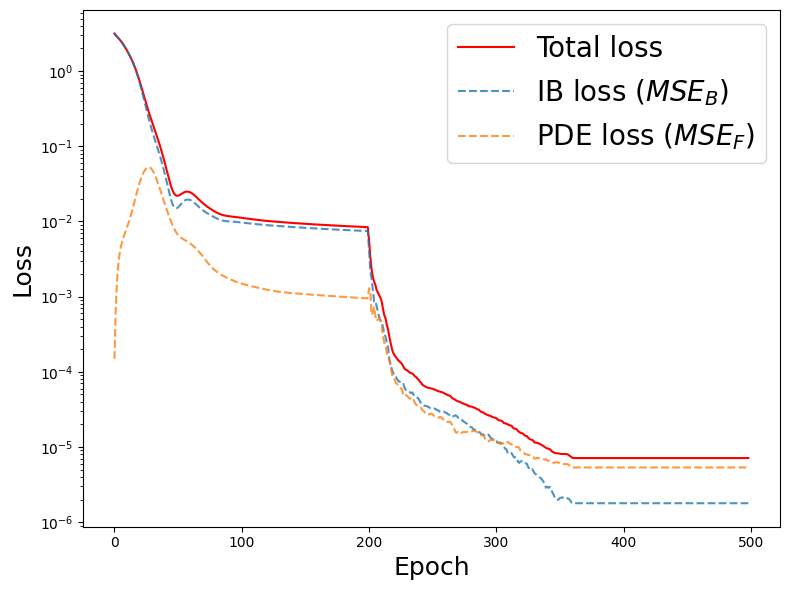

Final loss: 7.13649944827921e-06


In [3]:
TRAIN = False
# model_name = 'european'

if TRAIN:
    nn = torch.nn.Sequential(
            torch.nn.Linear(2, 20),
            torch.nn.Tanh(),
            torch.nn.Linear(20, 20),
            torch.nn.Tanh(),
            torch.nn.Linear(20, 1)
    )
    model = VanillaOptionPINN(nn, K, T, r, sigma, S_inf,
                              type='put', style='european',
                              device=device).to(device)
    loss_weights = (1., 1., 1.)

    training_time = time()
    # First train with Adam
    model.fit(tau_ib, S_ib, V_ib,
              tau_pde=None, S_pde=None,
              valid=False,
              N_pde=N_pde, sampling='sobol', resample=0,
              loss_weights=loss_weights,
              epochs=200, optimizer='adam', lr=0.005)
    # Then train with L-BFGS
    model.fit(tau_ib, S_ib, V_ib,
              tau_pde=None, S_pde=None,
              valid=False,
              N_pde=N_pde, sampling='sobol', resample=0,
              loss_weights=loss_weights,
              epochs=300, optimizer='lbfgs', line_search_fn='strong_wolfe')
    training_time = time() - training_time
    print('Training time:', training_time)
    # save model
    torch.save(model, f'models/{model_name}.pt')

model = torch.load(f'models/european_put/{model_name}.pt', map_location=device)
print(model)
print('Number of parameters:', sum(p.numel() for p in model.parameters()))
model.plot_history(save=True, title='', figsize=(8, 6), fontsize=18, file_name=f'data/images/loss_{model_name}.pdf')
print('Final loss:', model.loss_history['total'][-1])

### Error Analysis and Comparison to Crank Nicolson

RMSE: 0.0003342588046899243
MPE 0.02920978548033948


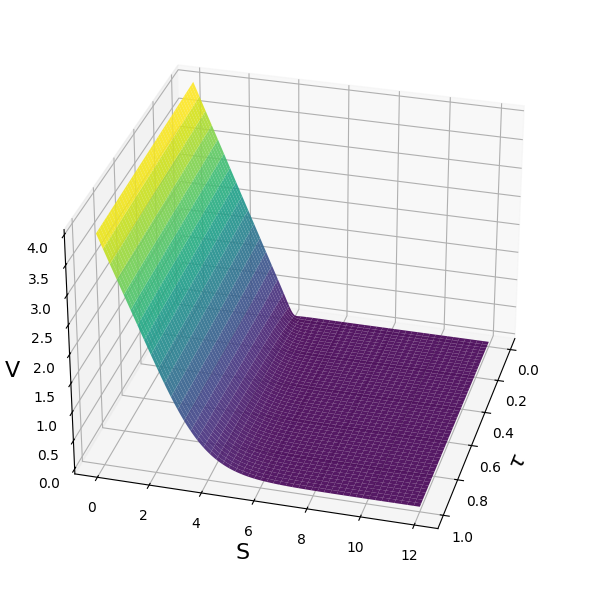

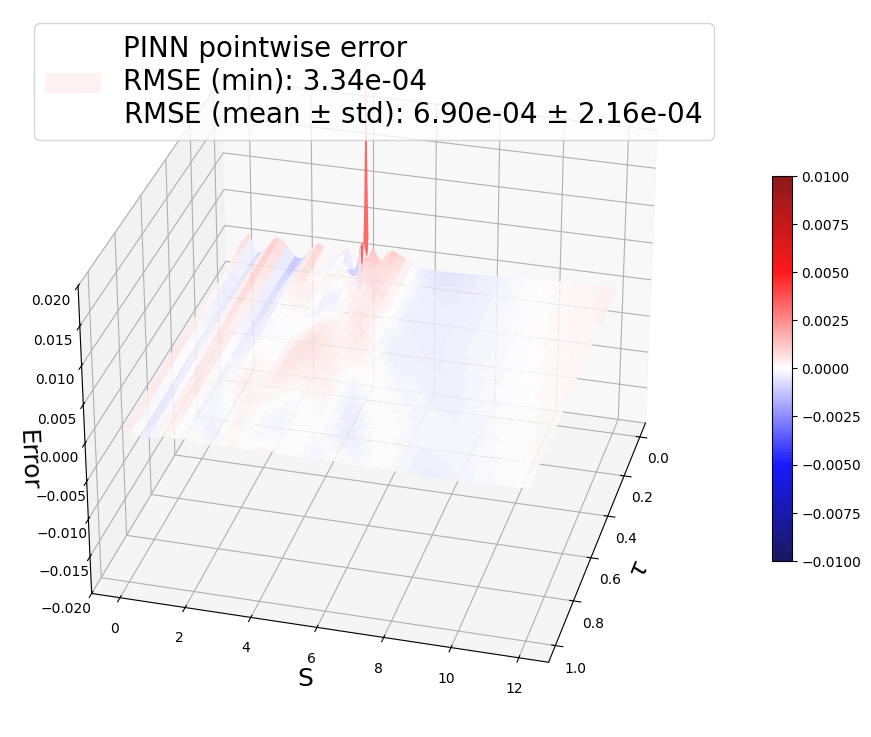

In [7]:
SAVE_FIG = True
model_name = f'european_put_{best_idx}'
model = torch.load(f'models/european_put/{model_name}.pt', map_location=device)

S_eval = torch.linspace(0, S_inf, 1000)
tau_eval = torch.linspace(0, T, 1000)
S_eval, tau_eval = torch.meshgrid(S_eval, tau_eval, indexing='xy')
V_pred = model(tau_eval.reshape(-1, 1), S_eval.reshape(-1, 1)).detach().numpy().reshape(1000, 1000)

S_eval = np.linspace(0, S_inf, 1000)
tau_eval = np.linspace(0, T, 1000)
S_eval, tau_eval = np.meshgrid(S_eval, tau_eval)
V_true = V_BS(tau_eval, S_eval, K, r, sigma, 'put')
V_err = V_pred - V_true
mse = np.mean(V_err**2)
rmse = np.sqrt(mse)
print('RMSE:', rmse)
print('MPE', np.max(np.abs(V_err)))

# 3d plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(tau_eval, S_eval, V_pred,
                       cmap='viridis', alpha=0.9)
ax.set_xlabel(r'$\tau$', fontsize=16)
ax.set_ylabel('S', fontsize=16)
ax.set_zlabel('V', fontsize=16)
ax.view_init(elev=30, azim=15)
plt.tight_layout()
if SAVE_FIG:
    plt.savefig('./data/images/sol_european_3d.pdf', bbox_inches='tight')
plt.show()

# plot error surface
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(tau_eval, S_eval, V_err,
                       label=f'PINN pointwise error\nRMSE (min): {rmse:.2e}\nRMSE (mean $\pm$ std): {RMSE_mean:.2e} $\pm$ {RMSE_std:.2e}',
                       cmap='seismic', vmin=-0.01, vmax=0.01, alpha=0.9)
cbar = fig.colorbar(surf, location='right', shrink=0.5)
ax.set_zlim(-0.02, 0.02)
ax.set_xlabel(r'$\tau$', fontsize=18)
ax.set_ylabel('S', fontsize=18)
ax.set_zlabel('Error', fontsize=18)
plt.legend(fontsize=20, loc='upper right')
ax.view_init(elev=30, azim=15)
plt.tight_layout()
if SAVE_FIG:
    plt.savefig('./data/images/sol_european_3d_err.pdf', bbox_inches='tight')
plt.show()

RMSE: 0.000292092337416343
MPE 0.026666659533023017


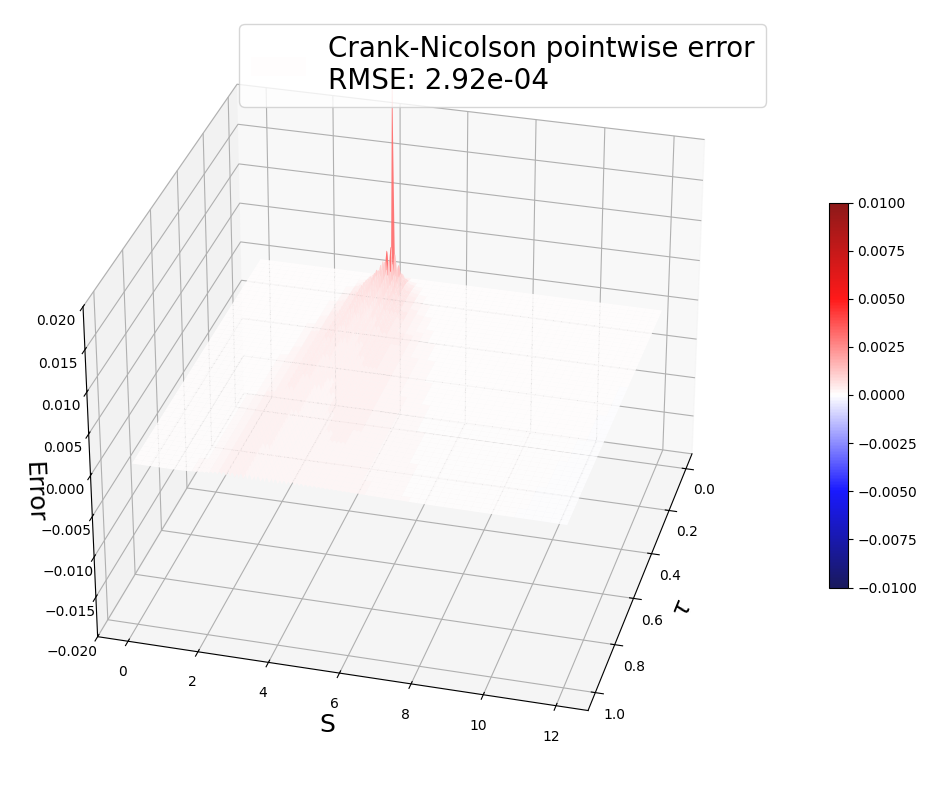

In [8]:
from scipy.interpolate import RegularGridInterpolator

SAVE_FIG = True

# Crank-Nicolson solution
V_CN, S_CN, t_CN = V_BS_CN(100, 100, K, T, r, sigma, S_inf=K*3, type='put', style='european')
V_CN = V_CN.T

# interpolate CN solution on eval grid
interpolator = RegularGridInterpolator((S_CN, t_CN), V_CN, method='linear', bounds_error=False, fill_value=np.nan)
S_eval = np.linspace(0, S_inf, 1000)
tau_eval = np.linspace(0, T, 1000)
S_eval, tau_eval = np.meshgrid(S_eval, tau_eval)
V_pred_CN = interpolator((S_eval, tau_eval))

# compute error metrics
V_true = V_BS(tau_eval, S_eval, K, r, sigma)
V_err_CN = V_pred_CN - V_true
MSE_CN = np.mean(V_err_CN**2)
RMSE_CN = np.sqrt(MSE_CN)
print('RMSE:', RMSE_CN)
print('MPE', np.max(np.abs(V_err_CN)))

# plot error surface
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(tau_eval, S_eval, V_err_CN, label=f'Crank-Nicolson pointwise error\nRMSE: {RMSE_CN:.2e}',
                       cmap='seismic', vmin=-0.01, vmax=0.01, alpha=0.9)
cbar = fig.colorbar(surf, location='right', shrink=0.5)
ax.set_zlim(-0.02, 0.02)
ax.set_xlabel(r'$\tau$', fontsize=18)
ax.set_ylabel('S', fontsize=18)
ax.set_zlabel('Error', fontsize=18)
plt.legend(fontsize=20, loc='upper right')
ax.view_init(elev=30, azim=15)
plt.tight_layout()
if SAVE_FIG:
    plt.savefig('./data/images/sol_european_cn_err.pdf', bbox_inches='tight')
plt.show()

### Greeks

Delta RMSE: 0.001748889352406479
Delta MPE: 0.045175283415923584


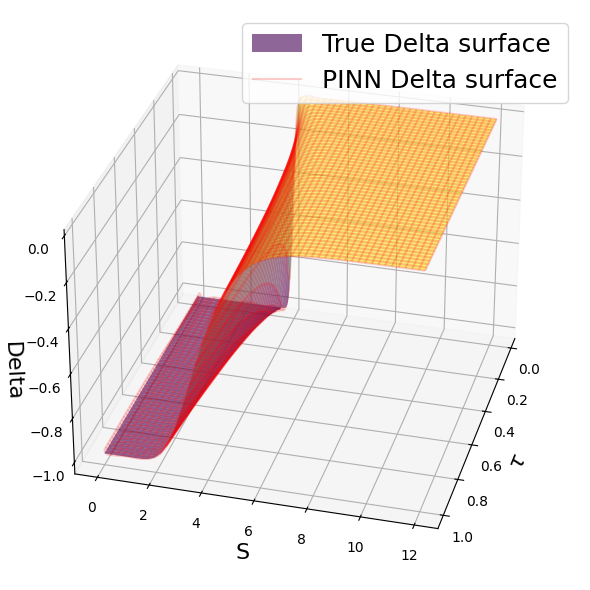

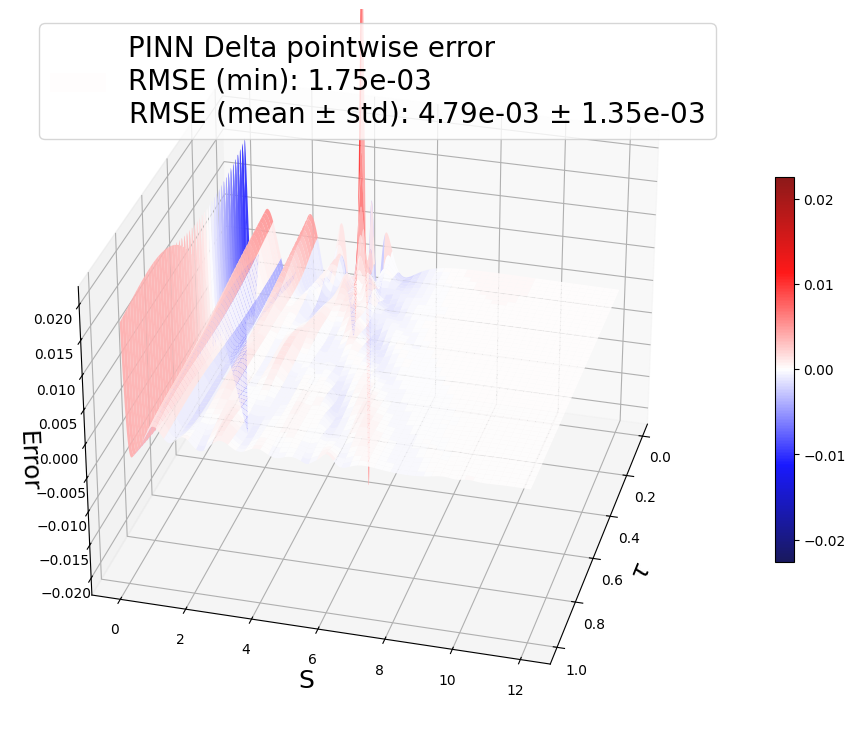

Theta RMSE: 0.004763146165793667
Theta MPE: 0.40148986982888113


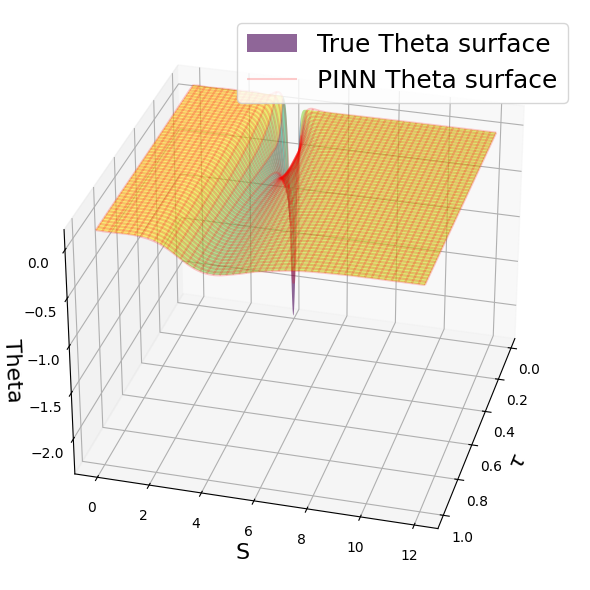

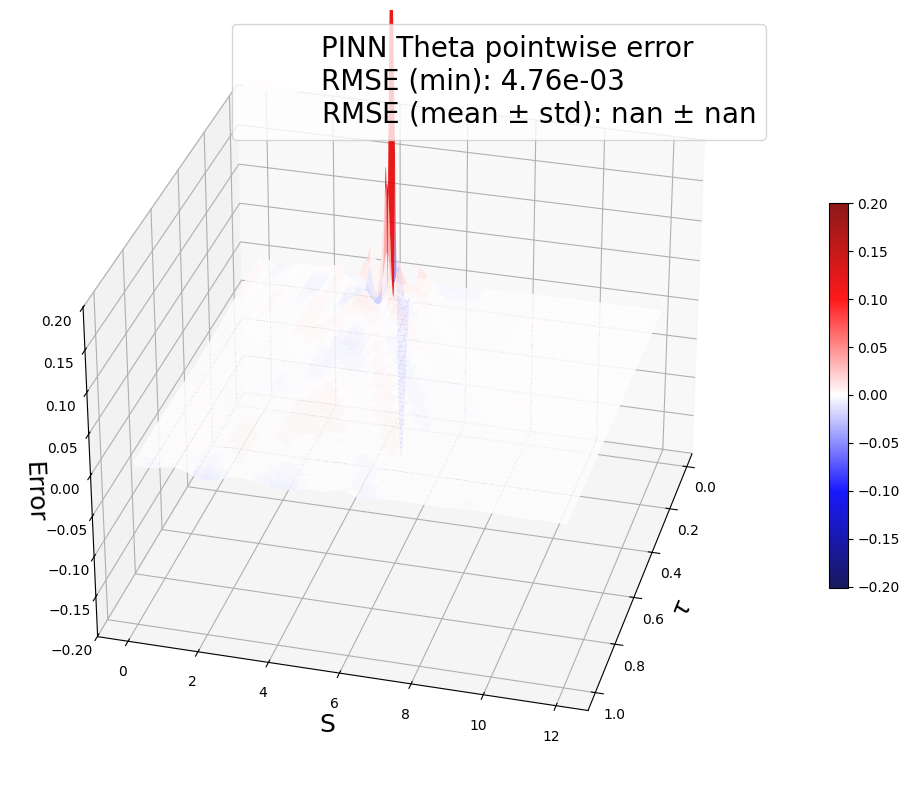

Gamma RMSE: 0.03127972885646336
Gamma MPE: 0.8823611736297607


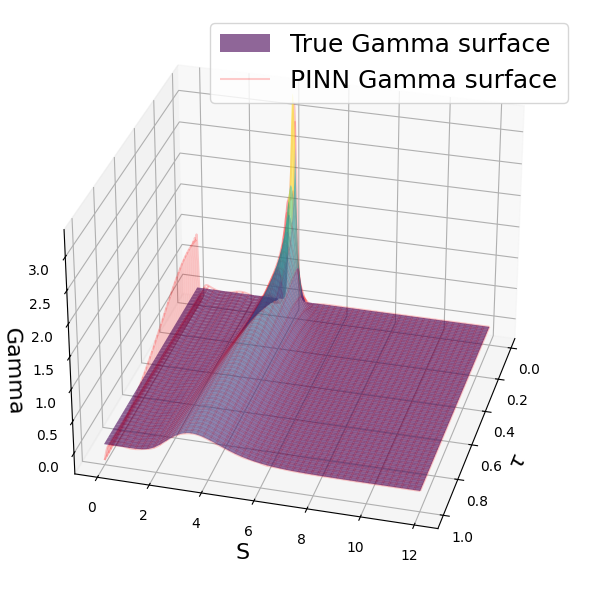

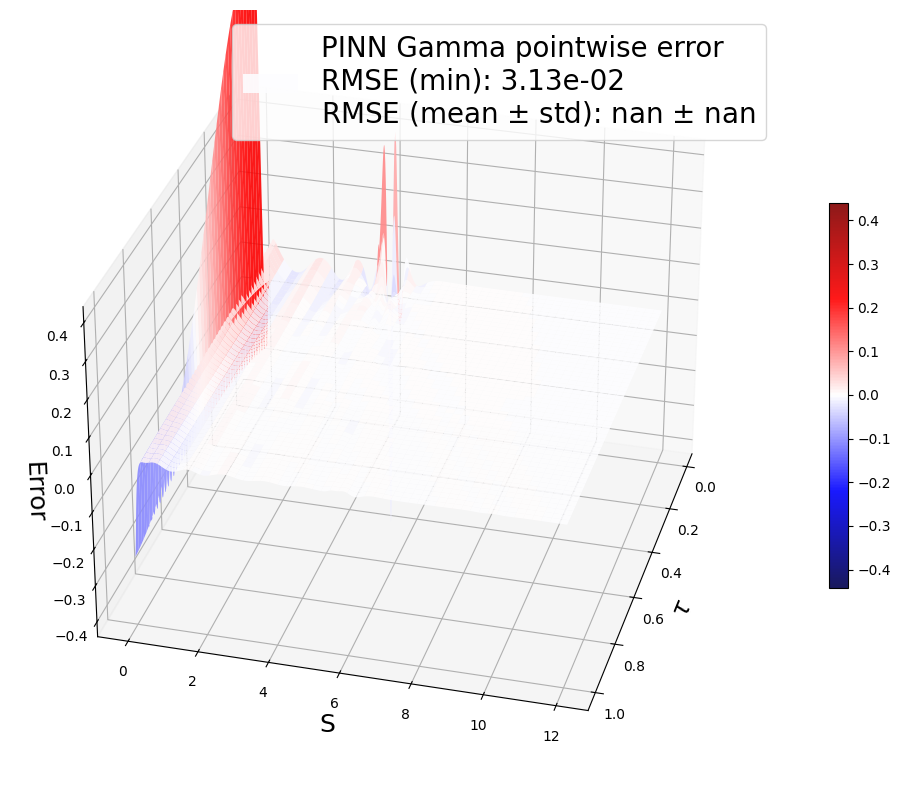

Charm RMSE: 0.06764280185345713
Charm MPE: 6.640773309322304


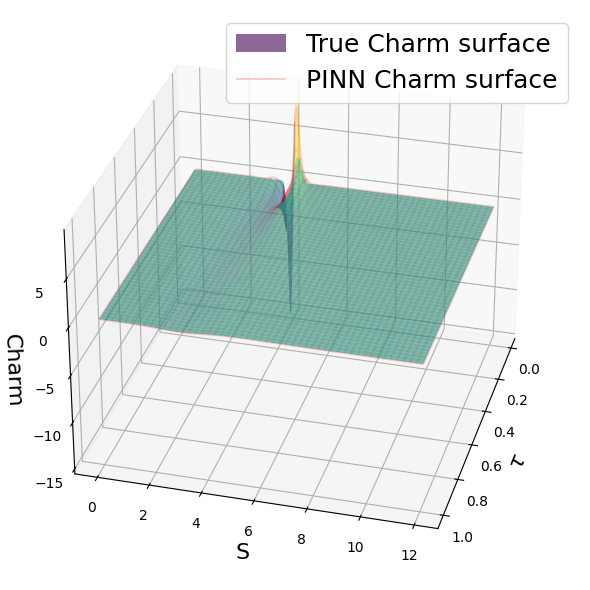

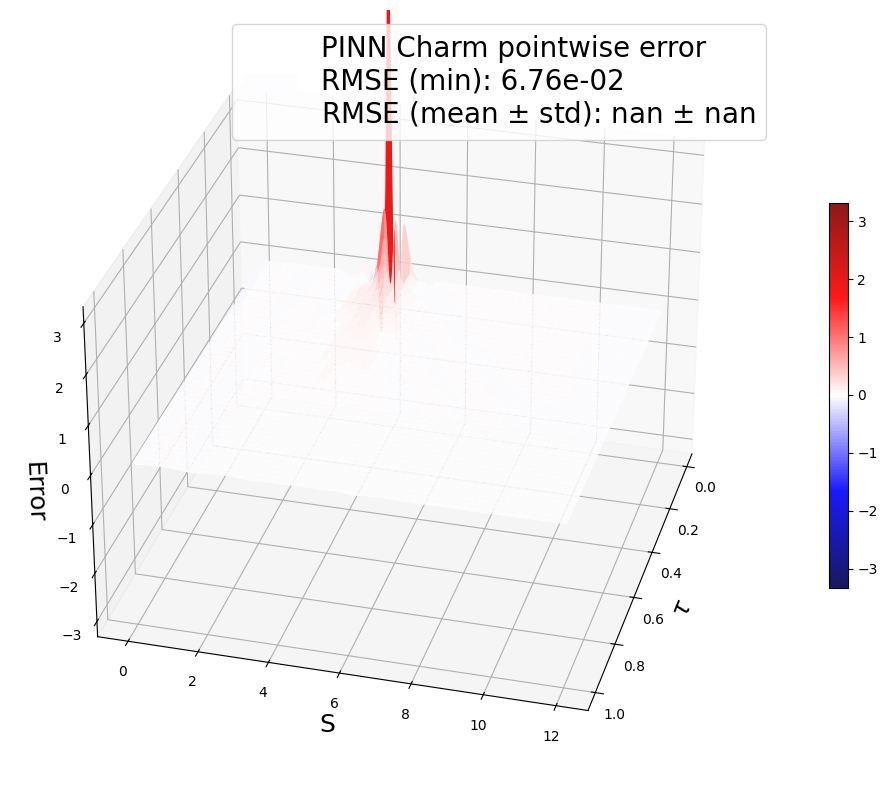

Speed RMSE: 0.6810884836244754
Speed MPE: 15.847999572753906


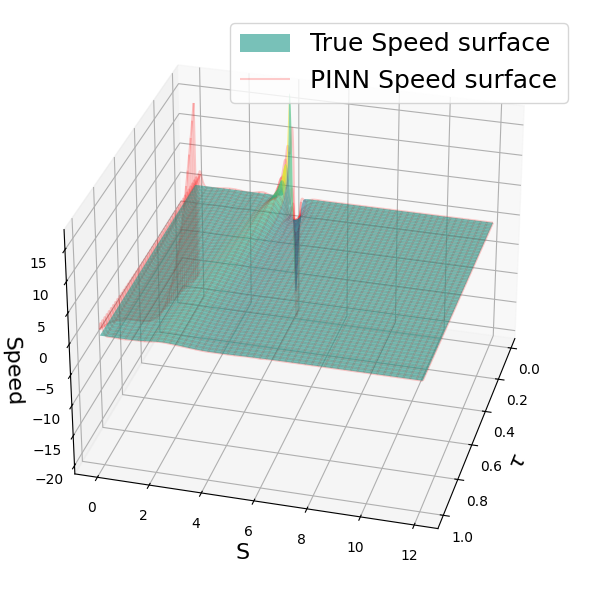

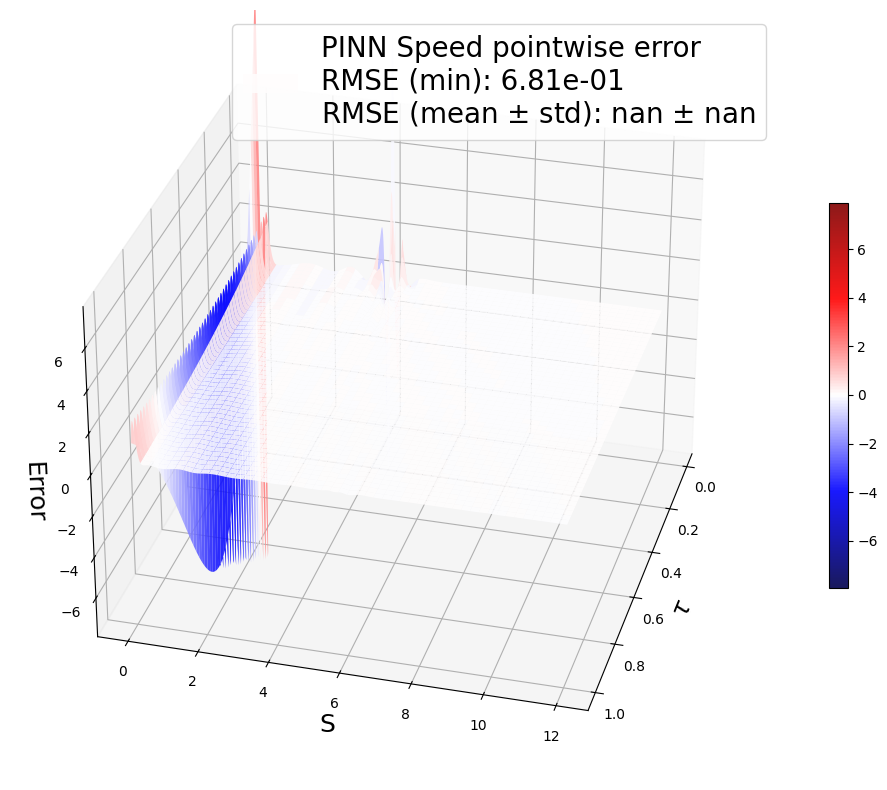

Color RMSE: 0.5888056443504247
Color MPE: 64.0904802442777


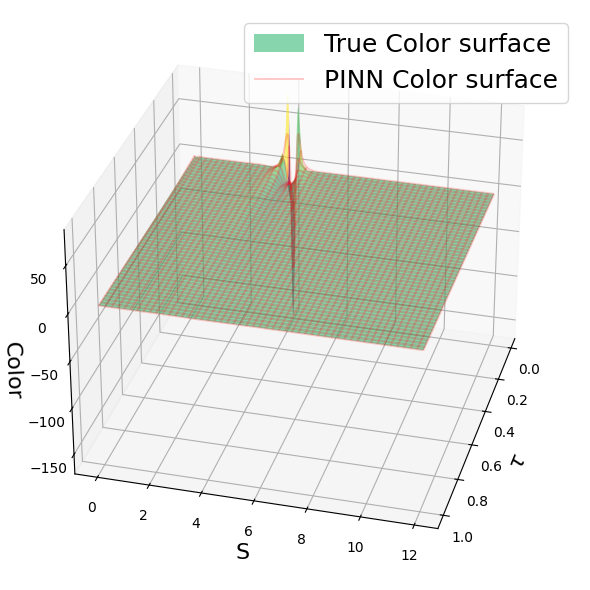

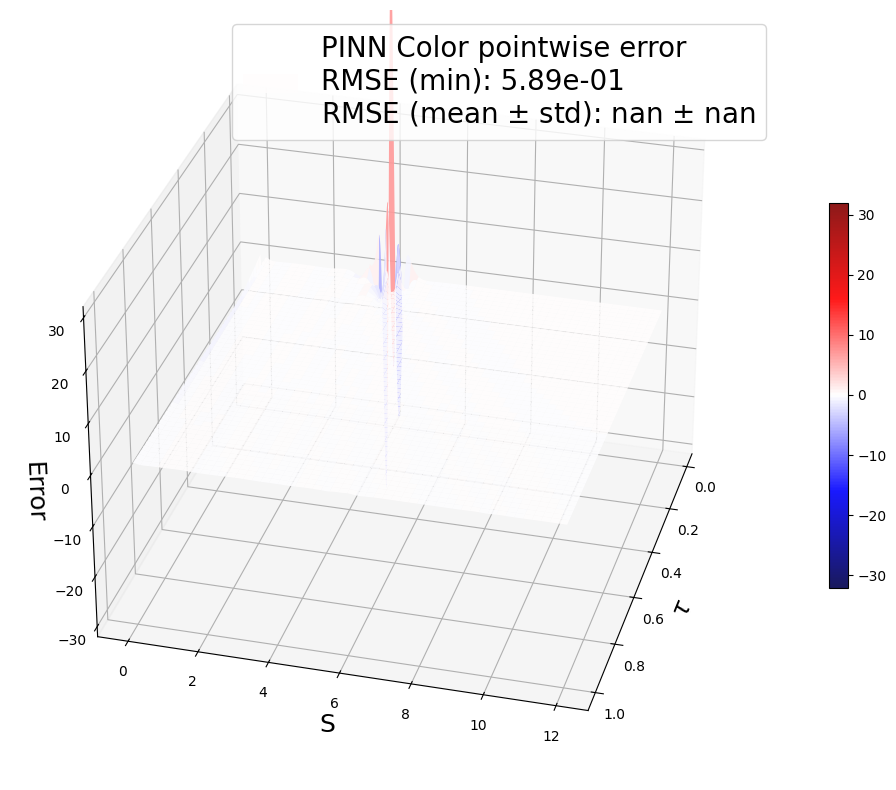

In [ ]:
SAVE_FIG = True
model_name = f'european_put_{best_idx}'
model = torch.load(f'models/european_put/{model_name}.pt', map_location=device)

epsilon = max(np.finfo(float).eps, 1e-2)
S_eval = torch.linspace(0, S_inf, 1000)
tau_eval = torch.linspace(epsilon, T, 1000)
S_eval, tau_eval = torch.meshgrid(S_eval, tau_eval, indexing='xy')
S_eval.requires_grad = True
tau_eval.requires_grad = True
S_eval_np = np.linspace(0, S_inf, 1000)
tau_eval_np = np.linspace(epsilon, T, 1000)
S_eval_np, tau_eval_np = np.meshgrid(S_eval_np, tau_eval_np)

for greek in GREEKS:
    greek_pred = model.evaluate_greeks(tau_eval.reshape(-1, 1), S_eval.reshape(-1, 1), greek).detach().cpu().numpy().reshape(1000, 1000)
    if np.isnan(greek_pred).any():
        raise ValueError(f'NaN in {greek}_pred')
    greek_true = european_option_greeks(tau_eval_np, S_eval_np, K, r, sigma, greek, 'put')
    greek_err = greek_pred - greek_true
    rmse_greek = np.sqrt(np.mean(greek_err**2))
    mpe_greek = np.max(np.abs(greek_err))
    print(f'{greek} RMSE:', rmse_greek)
    print(f'{greek} MPE:', mpe_greek)

    # plot greek surface
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(tau_eval_np, S_eval_np, greek_true,
                    label=f'True {greek.lower()} surface',
                    cmap='viridis', alpha=0.6)
    ax.plot_wireframe(tau_eval_np, S_eval_np, greek_pred,
                      label=f'PINN {greek.lower()} surface',
                      color='red', alpha=0.2)
    ax.set_xlabel(r'$\tau$', fontsize=16)
    ax.set_ylabel('S', fontsize=16)
    ax.set_zlabel(f'{greek}', fontsize=16)
    ax.view_init(elev=30, azim=15)
    plt.legend(fontsize=18, loc='upper right')
    plt.tight_layout()
    if SAVE_FIG:
        plt.savefig('./data/images/delta_european.pdf', bbox_inches='tight')
    plt.show()

    # plot greek error surface
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(tau_eval_np, S_eval_np, greek_err,
                           label=f'PINN {greek} pointwise error\nRMSE (min): {rmse_greek:.2e}\nRMSE (mean $\pm$ std): {RMSE_greeks_mean[greek]:.2e} $\pm$ {RMSE_greeks_std[greek]:.2e}',
                           cmap='seismic', vmin=-mpe_greek/2, vmax=mpe_greek/2, alpha=0.9)
    cbar = fig.colorbar(surf, location='right', shrink=0.5)
    ax.set_zlim(-mpe_greek/2, mpe_greek/2)
    ax.set_xlabel(r'$\tau$', fontsize=18)
    ax.set_ylabel('S', fontsize=18)
    ax.set_zlabel('Error', fontsize=18)
    plt.legend(fontsize=20, loc='upper right')
    ax.view_init(elev=30, azim=15)
    plt.tight_layout()
    if SAVE_FIG:
        plt.savefig(f'./data/images/{greek.lower()}_european_err.pdf', bbox_inches='tight')
    plt.show()

## American Call Option

Recovering European call

In [ ]:
# parameters
K = 4
sigma = 0.3
r = 0.03
T = 1
S_inf = 3 * K
N_pde = 2500

# load data
ib = torch.load('data/european_call_ib_sobol.pt')
S_ib, tau_ib, V_ib = ib['S'], ib['tau'], ib['V']

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cpu


No collocation points provided
Sampling 5000 collocation points (sobol)
Optimizer: adam
Device: cpu
Epoch 100/300    |    Loss: 0.05440779495984316
Epoch 200/300    |    Loss: 0.007405072450637817
Epoch 300/300    |    Loss: 0.004589937161654234
No collocation points provided
Sampling 5000 collocation points (sobol)
Optimizer: lbfgs
Device: cpu
Epoch 100/400    |    Loss: 0.000155225792696001
Epoch 200/400    |    Loss: 0.00011382860611774959
Epoch 300/400    |    Loss: 0.00011382860611774959
Epoch 400/400    |    Loss: 0.00011382860611774959
Training time: 64.27981901168823
VanillaOptionPINN(
  (V_nn): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Tanh()
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Tanh()
    (6): Linear(in_features=20, out_features=1, bias=True)
  )
)
Number of parameters: 921


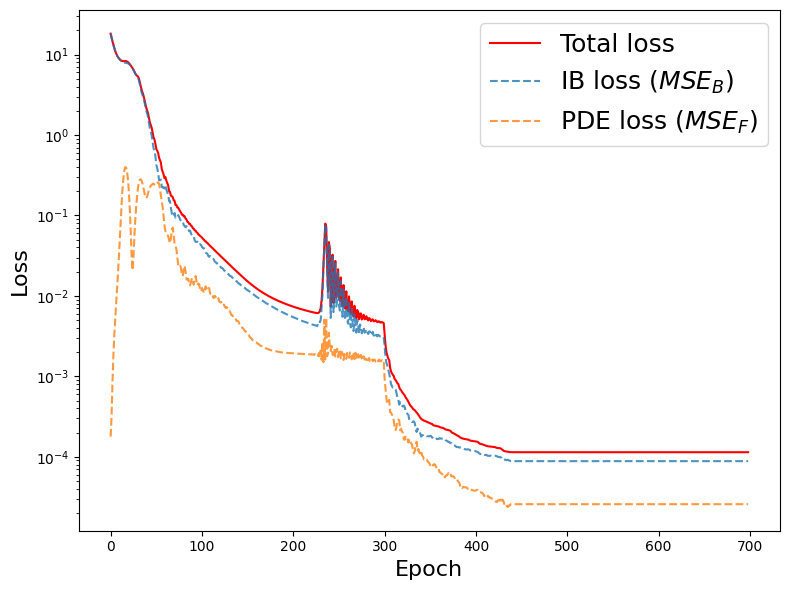

Final loss: 0.00011382860611774959


In [25]:
TRAIN = True
model_name = 'european_call'

if TRAIN:
    nn = torch.nn.Sequential(
            torch.nn.Linear(2, 20),
            torch.nn.Tanh(),
            torch.nn.Linear(20, 20),
            torch.nn.Tanh(),
            torch.nn.Linear(20, 20),
            torch.nn.Tanh(),
            torch.nn.Linear(20, 1)
    )
    model = VanillaOptionPINN(nn, K, T, r, sigma, S_inf,
                              type='call', style='european',
                              device=device).to(device)
    loss_weights = (1., 1., 1.)

    training_time = time()
    # First train with Adam
    model.fit(tau_ib, S_ib, V_ib,
              tau_pde=None, S_pde=None,
              valid=False,
              N_pde=N_pde, sampling='sobol', resample=0,
              loss_weights=loss_weights,
              epochs=300, optimizer='adam', lr=0.01)
    # Then train with L-BFGS
    model.fit(tau_ib, S_ib, V_ib,
              tau_pde=None, S_pde=None,
              valid=False,
              N_pde=N_pde, sampling='sobol', resample=0,
              loss_weights=loss_weights,
              epochs=400, optimizer='lbfgs', line_search_fn='strong_wolfe')
    training_time = time() - training_time
    print('Training time:', training_time)
    # save model
    torch.save(model, f'models/{model_name}.pt')

model = torch.load(f'models/{model_name}.pt', map_location=device)
print(model)
print('Number of parameters:', sum(p.numel() for p in model.parameters()))
model.plot_history(save=False, title='', figsize=(8, 6), fontsize=16, file_name=f'data/images/loss_{model_name}.pdf')
print('Final loss:', model.loss_history['total'][-1])

MSE: 3.4549859882230047e-06
RMSE: 0.0018587592604269669
-0.021149039268493652 0.07091724872589111


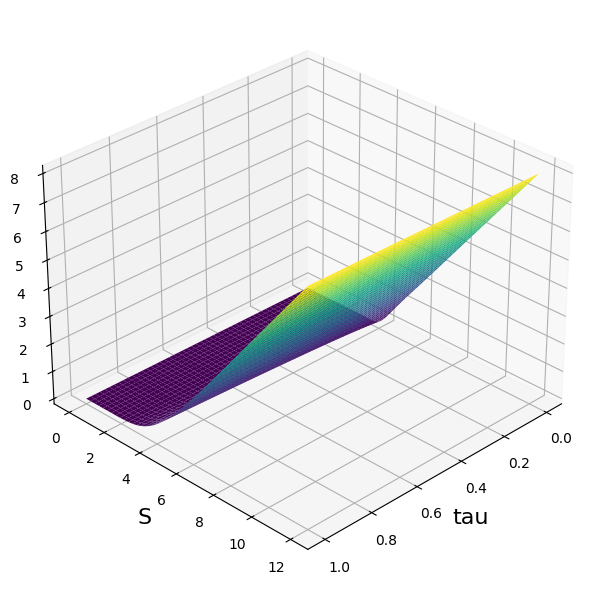

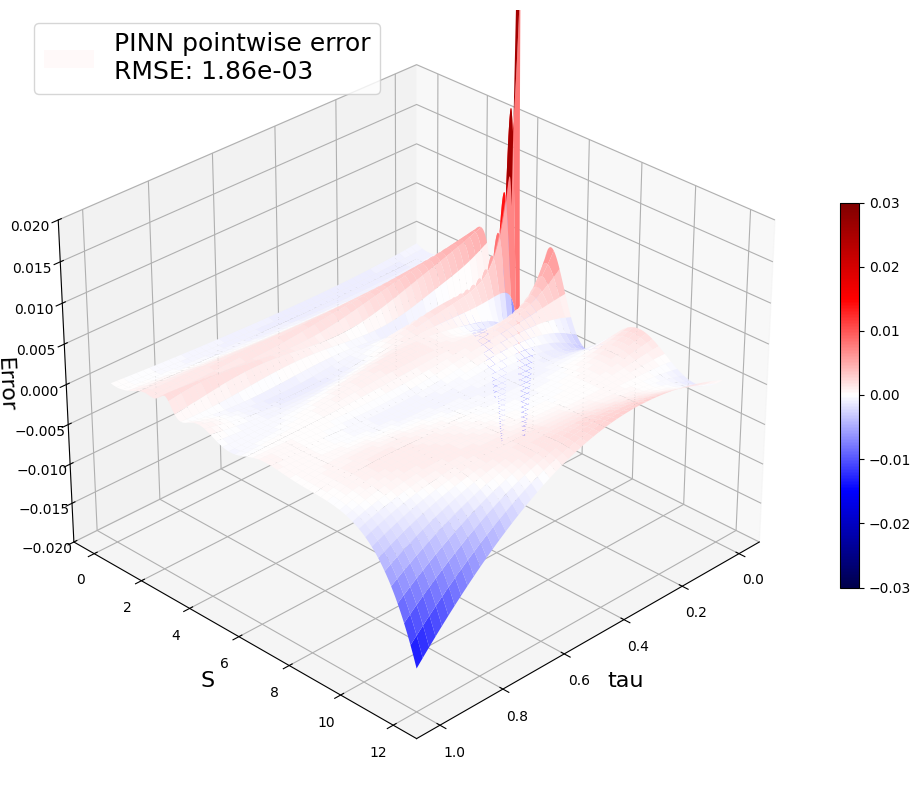

In [26]:
SAVE_FIG = False
# model_name = 'european_put_2mlp20'
# model = torch.load(f'models/{model_name}.pt', map_location=device)

S_eval = torch.linspace(0, S_inf, 1000)
tau_eval = torch.linspace(0, T, 1000)
# S_eval, tau_eval = torch.meshgrid(S_eval, tau_eval)  # torch meshgrid uses different indexing
S_eval, tau_eval = torch.meshgrid(S_eval, tau_eval, indexing='xy')
V_pred = model(tau_eval.reshape(-1, 1), S_eval.reshape(-1, 1)).detach().numpy().reshape(1000, 1000)#.T

# compute error metrics
# Using np.meshgrid, torch.meshgrid uses different indexing
S_eval = np.linspace(0, S_inf, 1000)
tau_eval = np.linspace(0, T, 1000)
S_eval, tau_eval = np.meshgrid(S_eval, tau_eval)
V_true = V_BS(tau_eval, S_eval, K, r, sigma, 'call')
# fig = plt.figure(figsize=(8, 6))
# ax = fig.add_subplot(111, projection='3d')
# surf = ax.plot_surface(S_eval, tau_eval, V_true, cmap='viridis')
V_err = V_pred - V_true
MSE = np.mean(V_err**2)
RMSE = np.sqrt(MSE)
print('MSE:', MSE)
print('RMSE:', RMSE)
print(V_err.min(), V_err.max())

# 3d plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(tau_eval, S_eval, V_pred, cmap='viridis')
ax.set_xlabel('tau', fontsize=16)
ax.set_ylabel('S', fontsize=16)
# ax.set_zlabel('V', fontsize=14)
ax.view_init(elev=30, azim=45)
plt.tight_layout()
if SAVE_FIG:
    plt.savefig('./data/images/sol_american_call_3d.pdf', bbox_inches='tight')
plt.show()

# plot error surface
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(tau_eval, S_eval, V_err, label=f'PINN pointwise error\nRMSE: {RMSE:.2e}', cmap='seismic', vmin=-0.03, vmax=0.03)
cbar = fig.colorbar(surf, location='right', shrink=0.5)
ax.set_zlim(-0.02, 0.02)
ax.set_xlabel('tau', fontsize=16)
ax.set_ylabel('S', fontsize=16)
ax.set_zlabel('Error', fontsize=16)
plt.legend(fontsize=18)
ax.view_init(elev=30, azim=45)
plt.tight_layout()
if SAVE_FIG:
    plt.savefig('./data/images/sol_american_call_3d_err.pdf', bbox_inches='tight')
plt.show()